Found 5428 rows with NaN values
Found 1857 rows with NaN values
Found 1848 rows with NaN values
                Feature       VIF
4          n_activities  2.928789
3          total_clicks  2.450341
2        weighted_score  1.690051
1       studied_credits  1.058987
0  num_of_prev_attempts  1.044495
5     date_registration  1.015347
Converged in [12] iterations

=== Model Performance ===
Validation Accuracy: 0.8534601810649072
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      3076
           1       0.86      0.86      0.86      3441

    accuracy                           0.85      6517
   macro avg       0.85      0.85      0.85      6517
weighted avg       0.85      0.85      0.85      6517

Test Accuracy: 0.8486660533578657
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3079
           1       0.86      0.86      0.86      3443

    accuracy                           0.85  

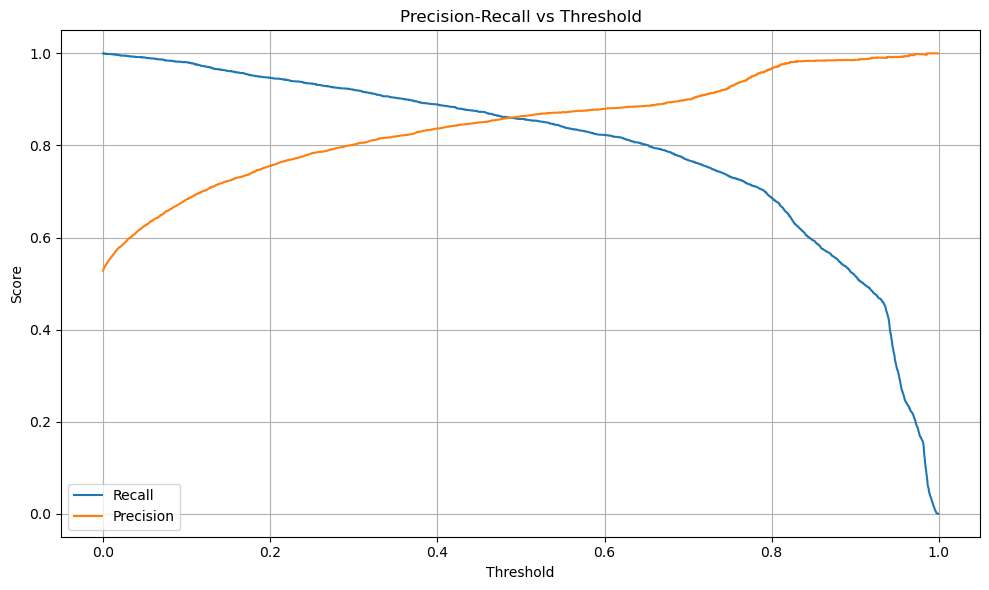

Best threshold with recall ≥ 0.90: 0.362
Recall: 0.900, Precision: 0.823

=== Evaluation at threshold 0.362 ===
Validation Accuracy: 0.844713825379776
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      3076
           1       0.82      0.90      0.86      3441

    accuracy                           0.84      6517
   macro avg       0.85      0.84      0.84      6517
weighted avg       0.85      0.84      0.84      6517

Test Accuracy: 0.8394664213431463
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3079
           1       0.82      0.90      0.86      3443

    accuracy                           0.84      6522
   macro avg       0.84      0.84      0.84      6522
weighted avg       0.84      0.84      0.84      6522

Validation ROC AUC: 0.9332
Test ROC AUC: 0.9292
Validation PR AUC: 0.9452
Test PR AUC: 0.9433

Top Important Features:
['weighted_score', 'total_clicks', 'studie

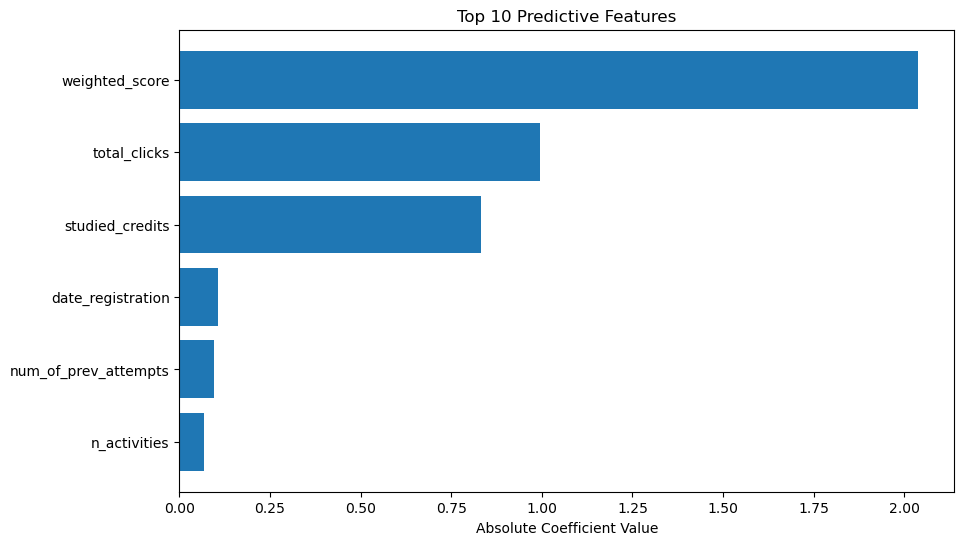


SHAP values for logistic regression:


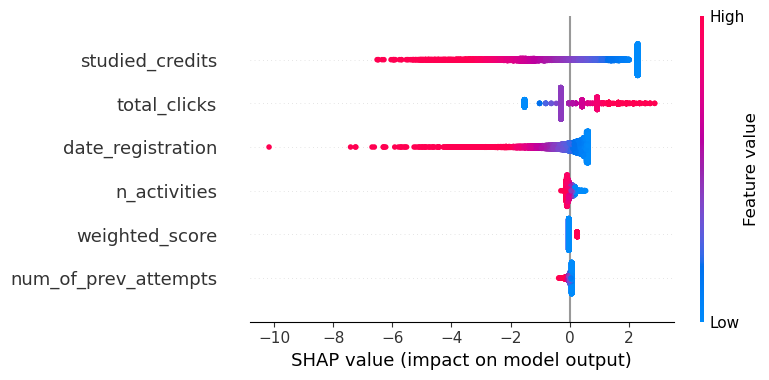

Top features by ANOVA F-test:
['weighted_score', 'n_activities', 'total_clicks', 'studied_credits', 'num_of_prev_attempts', 'date_registration']
Number of overlapping features: 6
Common features: ['total_clicks', 'date_registration', 'num_of_prev_attempts', 'n_activities', 'studied_credits', 'weighted_score']

SHAP values for anova (model agnostic):


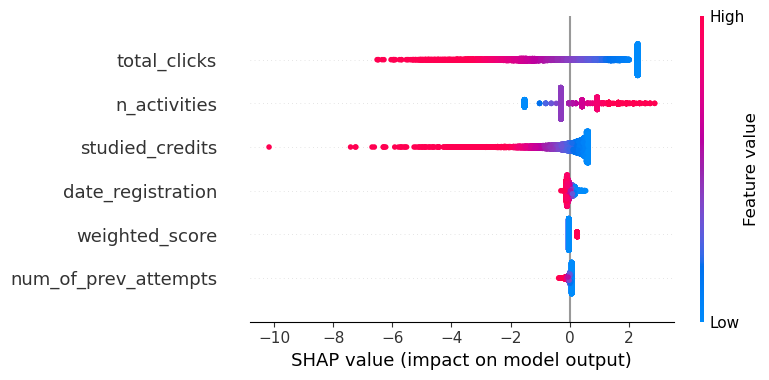


Selected 4 Significant Features (|coef| ≥ 0.1):
['weighted_score', 'total_clicks', 'studied_credits', 'date_registration']
Converged in [9] iterations

=== Model Performance ===
Validation Accuracy: 0.8525395120454197
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3076
           1       0.86      0.86      0.86      3441

    accuracy                           0.85      6517
   macro avg       0.85      0.85      0.85      6517
weighted avg       0.85      0.85      0.85      6517

Test Accuracy: 0.8472861085556578
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3079
           1       0.85      0.86      0.86      3443

    accuracy                           0.85      6522
   macro avg       0.85      0.85      0.85      6522
weighted avg       0.85      0.85      0.85      6522



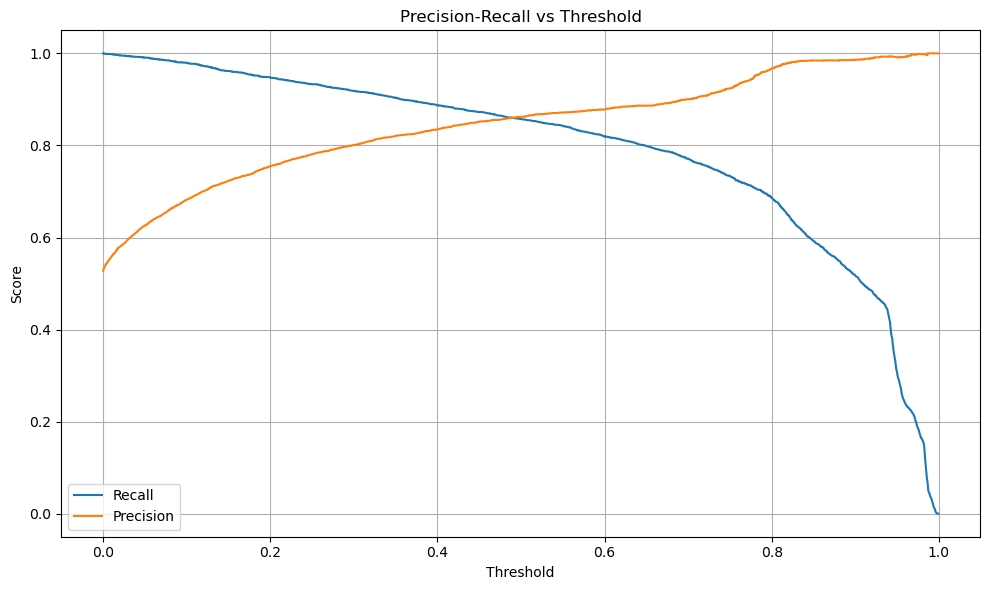

Best threshold with recall ≥ 0.90: 0.357
Recall: 0.900, Precision: 0.823

=== Evaluation at threshold 0.357 ===
Validation Accuracy: 0.8448672702163572
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      3076
           1       0.82      0.90      0.86      3441

    accuracy                           0.84      6517
   macro avg       0.85      0.84      0.84      6517
weighted avg       0.85      0.84      0.84      6517

Test Accuracy: 0.8394664213431463
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3079
           1       0.81      0.90      0.86      3443

    accuracy                           0.84      6522
   macro avg       0.84      0.84      0.84      6522
weighted avg       0.84      0.84      0.84      6522

Validation ROC AUC: 0.9327
Test ROC AUC: 0.9289
Validation PR AUC: 0.9448
Test PR AUC: 0.9430

Final Feature Impacts (|coef| ≥ 0.1):
             Feature  Coeff

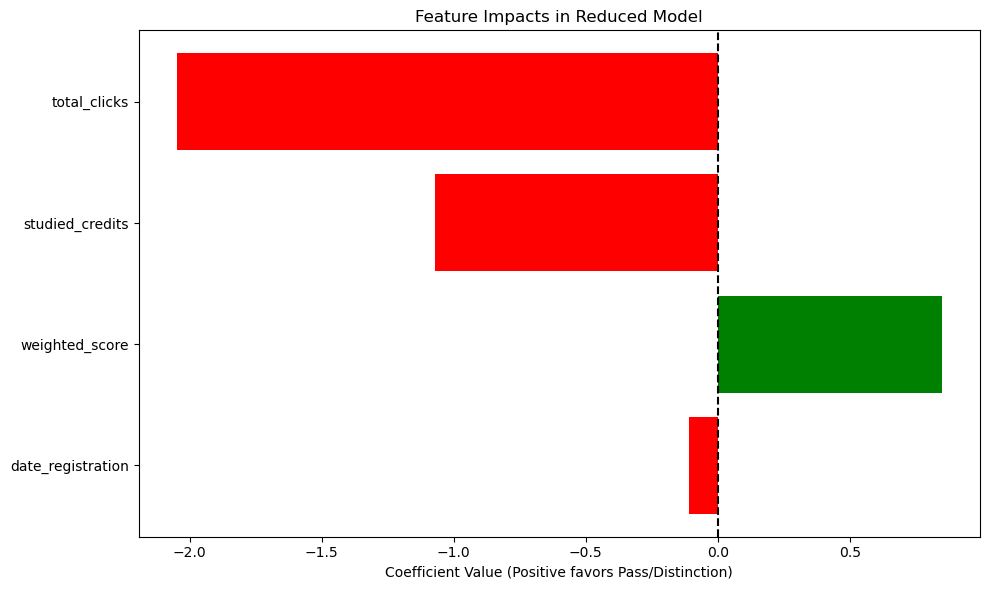


SHAP values for reduced model:


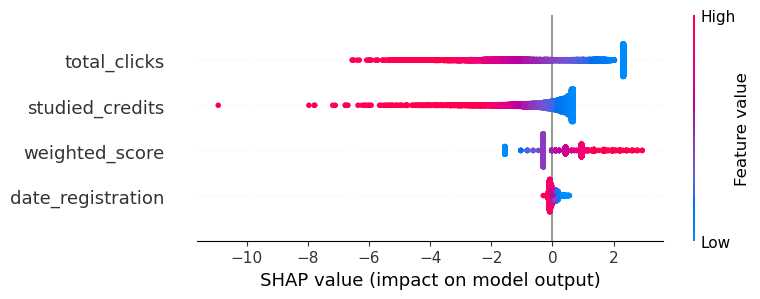

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

def prepare_data(set_dir):
    data_dir = Path.home() / "Desktop" / "Logistic Regression Skewness Fixed" / "constant"
    assessments = pd.read_csv(f"{data_dir}/assessments.csv")
    student_info = pd.read_csv(f"{set_dir}/student_info.csv")
    student_assessment = pd.read_csv(f"{set_dir}/student_assessment.csv")
    student_reg = pd.read_csv(f"{set_dir}/student_reg.csv")
    student_vle = pd.read_csv(f"{set_dir}/student_vle.csv")
    
    student_assessment = pd.merge(
        student_assessment, 
        assessments[['id_assessment', 'weight', 'assessment_type']], 
        on='id_assessment', 
        how='left'
    )

    student_assessment = student_assessment[student_assessment['weight'] > 0] 
  # student_assessment = student_assessment[student_assessment['assessment_type'] != 'Exam']

    # Aggregate assessments per student
    student_agg = student_assessment.groupby(
        ['code_module', 'code_presentation', 'id_student']
    ).agg(
        mean_score=('score', 'mean'),
        max_score=('score', 'max'),
        min_score=('score', 'min'),
        n_assessments=('score', 'count'),
        weighted_score=('score', lambda x: (x * student_assessment.loc[x.index, 'weight']).sum() / 100)
    ).reset_index()

    vle_agg = student_vle.groupby(['code_module', 'code_presentation', 'id_student']).agg(
    total_clicks=('sum_click', 'sum'),
    n_activities=('id_site', 'nunique')
    ).reset_index()
    
    merge_keys = ['code_module', 'code_presentation', 'id_student']
    df = student_info.merge(student_agg, on=merge_keys, how='left')
    df = df.merge(vle_agg, on=merge_keys, how='left')
    df = pd.merge(df, student_reg, on=merge_keys, how='left')

    nan_rows = df[df.isna().any(axis=1)]
    print(f"Found {len(nan_rows)} rows with NaN values")
    # print(nan_rows.head())

    assessment_cols = ['mean_score', 'max_score', 'min_score', 'weighted_score']
    df[assessment_cols] = df[assessment_cols].fillna(-1)  # -1 indicates no assessments
    df['n_assessments'] = df['n_assessments'].fillna(0)   # 0 assessments completed
    
    df['total_clicks'] = df['total_clicks'].fillna(0)
    df['n_activities'] = df['n_activities'].fillna(0)

    df = df.drop(columns=['date_unregistration', 'mean_score', 'max_score', 'min_score'], errors='ignore')

    df = df.drop(columns=['n_assessments']) # because of multicollinearity
    # Dropping equity related  features
    df = df.drop(columns=['disability_Y', 'age_band', 'imd_band', 'highest_education', 'gender_M'])
    # Dropping regions
    df = df.drop(columns=[reg for reg in df.columns if reg.startswith('region_')])
    
    y = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)  # binary target

    X = df.drop(columns=['code_module', 'code_presentation', 'id_student', 'final_result'])
    
    return X, y

def plot_precision_recall_threshold_curve(y_true, y_probs, desired_recall=None):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(10, 6))
    # recall array has one more element than thresholds, so slice recall[:-1] 
    plt.plot(thresholds, recall[:-1], label='Recall')
    # precision array has one more element than thresholds, so slice precision[:-1] 
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if desired_recall:
        # Gets all indices where recall is at least desired_recall
        indices = np.where(recall >= desired_recall)[0]
        if len(indices) > 0:
            # Picks the one with the highest precision
            best_i = indices[np.argmax(precision[indices])]
            # Gets the threshold corresponding to that best index
            best_threshold = thresholds[best_i]
            print(f"Best threshold with recall ≥ {desired_recall:.2f}: {best_threshold:.3f}")
            print(f"Recall: {recall[best_i]:.3f}, Precision: {precision[best_i]:.3f}")
            return best_threshold
        else:
            print(f"No threshold found with recall ≥ {desired_recall}")
            return None
    return None


def evaluate_model(model, X_val, y_val, X_test, y_test):
    print("\n=== Model Performance ===")
    y_val_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))
    
    y_test_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    
    # Gets predicted probabilities for the positive class (1)
    y_val_probs = model.predict_proba(X_val)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]
    # Getting the best threshold from our function
    threshold = plot_precision_recall_threshold_curve(y_val, y_val_probs, desired_recall=0.9)

    if threshold is not None:
       # Converting the predicted probabilities on the validation set into binary predictions using the chosen threshold.
       y_val_pred_thresh = (y_val_probs >= threshold).astype(int)
       print(f"\n=== Evaluation at threshold {threshold:.3f} ===")
       print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_thresh))
       print(classification_report(y_val, y_val_pred_thresh))
    
       y_test_pred_thresh = (y_test_probs >= threshold).astype(int)
       print("Test Accuracy:", accuracy_score(y_test, y_test_pred_thresh))
       print(classification_report(y_test, y_test_pred_thresh))
        
    # Calculates AUC
    val_pr_auc = average_precision_score(y_val, y_val_probs)
    test_pr_auc = average_precision_score(y_test, y_test_probs)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    test_roc_auc = roc_auc_score(y_test, y_test_probs)
    
    print(f"Validation ROC AUC: {val_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print(f"Validation PR AUC: {val_pr_auc:.4f}")
    print(f"Test PR AUC: {test_pr_auc:.4f}")

def calc_shap_values(model_name, model, X_test, feature_names):
    print(f"\nSHAP values for {model_name}:")
    # Creates explainer and get Explanation object
    explainer = shap.LinearExplainer(model, X_test)
    shap_values = explainer(X_test)  # This returns an Explanation object
    
    # Summary plot
    shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)

def quick_dependence_plots(shap_exp, features, feature_names, n=5):
    plt.figure(figsize=(15, 3))
    
    # Get top n features by mean absolute SHAP value
    mean_abs_shap = np.mean(np.abs(shap_exp.values), axis=0)
    top_features = np.argsort(mean_abs_shap)[-n:][::-1]
    
    for i, feat_idx in enumerate(top_features):
        plt.subplot(1, n, i+1)
        
        # Create single-feature Explanation object
        temp_exp = shap.Explanation(
            values=shap_exp.values[:, feat_idx],
            base_values=shap_exp.base_values,
            data=features[:, feat_idx],
            feature_names=feature_names[feat_idx]
        )
        
        shap.plots.scatter(temp_exp, show=False)
        plt.title(feature_names[feat_idx])
        if i > 0: 
            plt.ylabel("")
            plt.gca().set_yticklabels([])
    
    plt.tight_layout()
    plt.show()


def compute_vif(scaled_data, original_columns):
    # Converts scaled features into DataFrame
    X_df = pd.DataFrame(scaled_data, columns=original_columns.columns)
    
    # Computes VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    
    # Shows high-VIF features
    print(vif_data.sort_values("VIF", ascending=False))

data_dir = Path.home() / "Desktop" / "Logistic Regression Skewness Fixed" / "constant"

X_train, y_train = prepare_data(data_dir / "train")
X_val, y_val = prepare_data(data_dir / "val")
X_test, y_test = prepare_data(data_dir / "test")

scaler = StandardScaler()

# Fitting only on training data, then transforming all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)

compute_vif(X_train_scaled, X_train)

# Training
model = LogisticRegression(
    penalty='l2',                    # Ridge regularization
    C=1.0,                           # Inverse of alpha (C = 1 / alpha); alpha=1e-4 -> C=1e4
    class_weight='balanced',         # Handles class imbalance
    solver='lbfgs',                  # Default solver, good for small to medium datasets
    max_iter=100,                    # Allows enough iterations to converge
    random_state=42                  # For reproducibility
)

model.fit(X_train_scaled, y_train)
print(f'Converged in {model.n_iter_} iterations')

evaluate_model(model, X_val_scaled, y_val, X_test_scaled, y_test)

# Gets feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(model.coef_[0]), # Absolute value of coefficients
    'Coefficient': model.coef_[0] # Raw coefficients for direction
}).sort_values('Importance', ascending=False)

top_coef_features = feature_importance['Feature'].tolist()
print("\nTop Important Features:")
print(top_coef_features)
print(feature_importance[feature_importance['Feature'].isin(top_coef_features)])

# Plots the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Predictive Features')
plt.gca().invert_yaxis()  # Show most important at top
plt.show()

calc_shap_values("logistic regression", model, X_test_scaled, top_coef_features)

# ====ANOVA======
selector = SelectKBest(f_classif, k='all') # This applies the ANOVA F-test to every feature.
selector.fit(X_train_scaled, y_train)

anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_score': selector.scores_
}).sort_values('F_score', ascending=False)

# Top features by ANOVA F-test
top_anova_features = anova_scores['Feature'].tolist()
print("Top features by ANOVA F-test:")
print(top_anova_features)

common_features = set(top_coef_features) & set(top_anova_features)
print(f"Number of overlapping features: {len(common_features)}")
print("Common features:", list(common_features))

calc_shap_values("anova (model agnostic)", model, X_test_scaled, top_anova_features)

# Filters features with absolute coefficient ≥ 0.1 from the logistic regression.
significant_features = feature_importance[feature_importance['Importance'] >= 0.1]['Feature'].tolist()

print(f"\nSelected {len(significant_features)} Significant Features (|coef| ≥ 0.1):")
print(significant_features)

# Get column indices for significant features
feature_indices = [i for i, col in enumerate(X_train.columns) if col in significant_features]

# Reducing datasets using column indices
# This is dimensionality reduction using manual feature selection, not PCA.
X_train_reduced = X_train_scaled[:, feature_indices]
X_val_reduced = X_val_scaled[:, feature_indices]
X_test_reduced = X_test_scaled[:, feature_indices]

model_reduced = LogisticRegression(
    penalty='l2',                    # Ridge regularization
    C=1e4,                           # Inverse of alpha (C = 1 / alpha); alpha=1e-4 -> C=1e4
    class_weight='balanced',         # Handles class imbalance
    solver='lbfgs',                  # Default solver, good for small to medium datasets
    max_iter=100,                    # Allows enough iterations to converge
    random_state=42                  # For reproducibility
)

model_reduced.fit(X_train_reduced, y_train)
print(f'Converged in {model_reduced.n_iter_} iterations')

evaluate_model(model_reduced, X_val_reduced, y_val, X_test_reduced, y_test)

# After model training on reduced features
final_coef = pd.DataFrame({
    'Feature': significant_features,
    'Coefficient': model_reduced.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFinal Feature Impacts (|coef| ≥ 0.1):")
print(final_coef)

# Plots feature importance
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in final_coef['Coefficient']]
plt.barh(final_coef['Feature'], final_coef['Coefficient'], color=colors)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Coefficient Value (Positive favors Pass/Distinction)')
plt.title('Feature Impacts in Reduced Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

calc_shap_values("reduced model", model_reduced, X_test_reduced, significant_features)


In [ ]:
pip install shap
